In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding

2025-06-21 20:38:47.991028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750516728.136253    5577 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750516728.178591    5577 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750516728.505084    5577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750516728.505109    5577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750516728.505110    5577 computation_placer.cc:177] computation placer alr

In [ ]:
def prepare_mnist_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    x_train_rgb = tf.image.resize(x_train, (32, 32))
    x_train_rgb = tf.image.grayscale_to_rgb(x_train_rgb)

    x_test_rgb = tf.image.resize(x_test, (32, 32))
    x_test_rgb = tf.image.grayscale_to_rgb(x_test_rgb)

    return x_train_rgb.numpy(), y_train, x_test_rgb.numpy(), y_test

In [ ]:
x_train, y_train, x_test, y_test = prepare_mnist_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_train.dtype, x_test.dtype

I0000 00:00:1750516745.233097    5577 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7013 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


((60000, 32, 32, 3),
 (60000,),
 (10000, 32, 32, 3),
 (10000,),
 dtype('float32'),
 dtype('float32'))

In [ ]:
def extract_features(model, x_input):
    x_preprocessed = preprocess_input(x_input.copy())
    features = model.predict(x_preprocessed, verbose=0)

    return features

In [ ]:
selected_images, selected_labels = [], []
for class_idx in range(10):
    idxs = np.where(y_test == class_idx)[0][:500]
    selected_images.append(x_test[idxs])
    selected_labels.extend(y_test[idxs])
x_plot = np.concatenate(selected_images, axis=0)
y_plot = np.array(selected_labels)

In [ ]:
x_plot.shape, y_plot.shape

((5000, 32, 32, 3), (5000,))

In [ ]:
pre_trained_model = MobileNetV2(include_top=False, input_shape=(32, 32, 3), pooling='avg')
pre_trained_features = extract_features(pre_trained_model, x_plot)
pre_trained_features.shape

/tmp/ipykernel_5577/4128436310.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(include_top=False, input_shape=(32, 32, 3), pooling='avg')


(5000, 1280)

In [ ]:
def train_mobilenetv2_backbone(x_train, y_train, num_classes=10, epochs=3, batch_size=32):
    # Step 1: Preprocess inputs
    x_train = x_train.astype("float32")
    x_train_prep = preprocess_input(x_train.copy())

    # Step 2: Load MobileNetV2 without the classification head
    backbone = MobileNetV2(include_top=False, input_shape=(32, 32, 3), pooling='avg')
    backbone.trainable = False  # Freeze all layers
    for layer in backbone.layers[-16:]: # Unfreeze only the last 16 layers
        layer.trainable=True

    # Step 3: Add classification head
    inputs = Input(shape=(32, 32, 3))
    x = backbone(inputs, training=True)
    outputs = Dense(num_classes, activation='softmax')(x)
    full_model = Model(inputs, outputs)

    # Step 4: Compile and train
    full_model.compile(optimizer=Adam(1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

    full_model.fit(x_train_prep, y_train,
                   validation_split=0.1,
                   epochs=epochs,
                   batch_size=batch_size,
                   verbose=1)

    # Step 5: Return only the trained backbone (feature extractor)
    return backbone

In [ ]:
fine_tuned_model = train_mobilenetv2_backbone(x_train, y_train)

/tmp/ipykernel_5577/4088820837.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(include_top=False, input_shape=(32, 32, 3), pooling='avg')


Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.7919 - loss: 0.6670 - val_accuracy: 0.7647 - val_loss: 1.0946
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9221 - loss: 0.2426 - val_accuracy: 0.9130 - val_loss: 0.3535
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9418 - loss: 0.1753 - val_accuracy: 0.9422 - val_loss: 0.1970


In [ ]:
fine_tuned_features = extract_features(fine_tuned_model, x_plot)

In [ ]:
def plot_dim_reductions(features, new_features, y_labels):
    methods = {
        "PCA": PCA(n_components=2),
        "t-SNE": TSNE(n_components=2, random_state=42),
        "MDS": MDS(n_components=2, random_state=42),
        "Isomap": Isomap(n_components=2),
        "LLE": LocallyLinearEmbedding(n_components=2)
    }

    fig, axs = plt.subplots(2, len(methods), figsize=(5 * len(methods), 10))
    axs = axs.reshape(2, len(methods))  # Ensure shape (2, 5)

    for col, (name, reducer) in enumerate(methods.items()):
        # Pretrained feature projection
        reduced_pre = reducer.fit_transform(features)
        axs[0, col].scatter(reduced_pre[:, 0], reduced_pre[:, 1], c=y_labels, cmap='tab10', s=15)
        axs[0, col].set_title(f"{name} (Pretrained)")
        axs[0, col].set_xticks([])
        axs[0, col].set_yticks([])

        # Fine-tuned feature projection
        reduced_fine = reducer.fit_transform(new_features)
        axs[1, col].scatter(reduced_fine[:, 0], reduced_fine[:, 1], c=y_labels, cmap='tab10', s=15)
        axs[1, col].set_title(f"{name} (Fine-tuned)")
        axs[1, col].set_xticks([])
        axs[1, col].set_yticks([])

    plt.tight_layout()
    plt.show()


/home/cseru/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/cseru/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


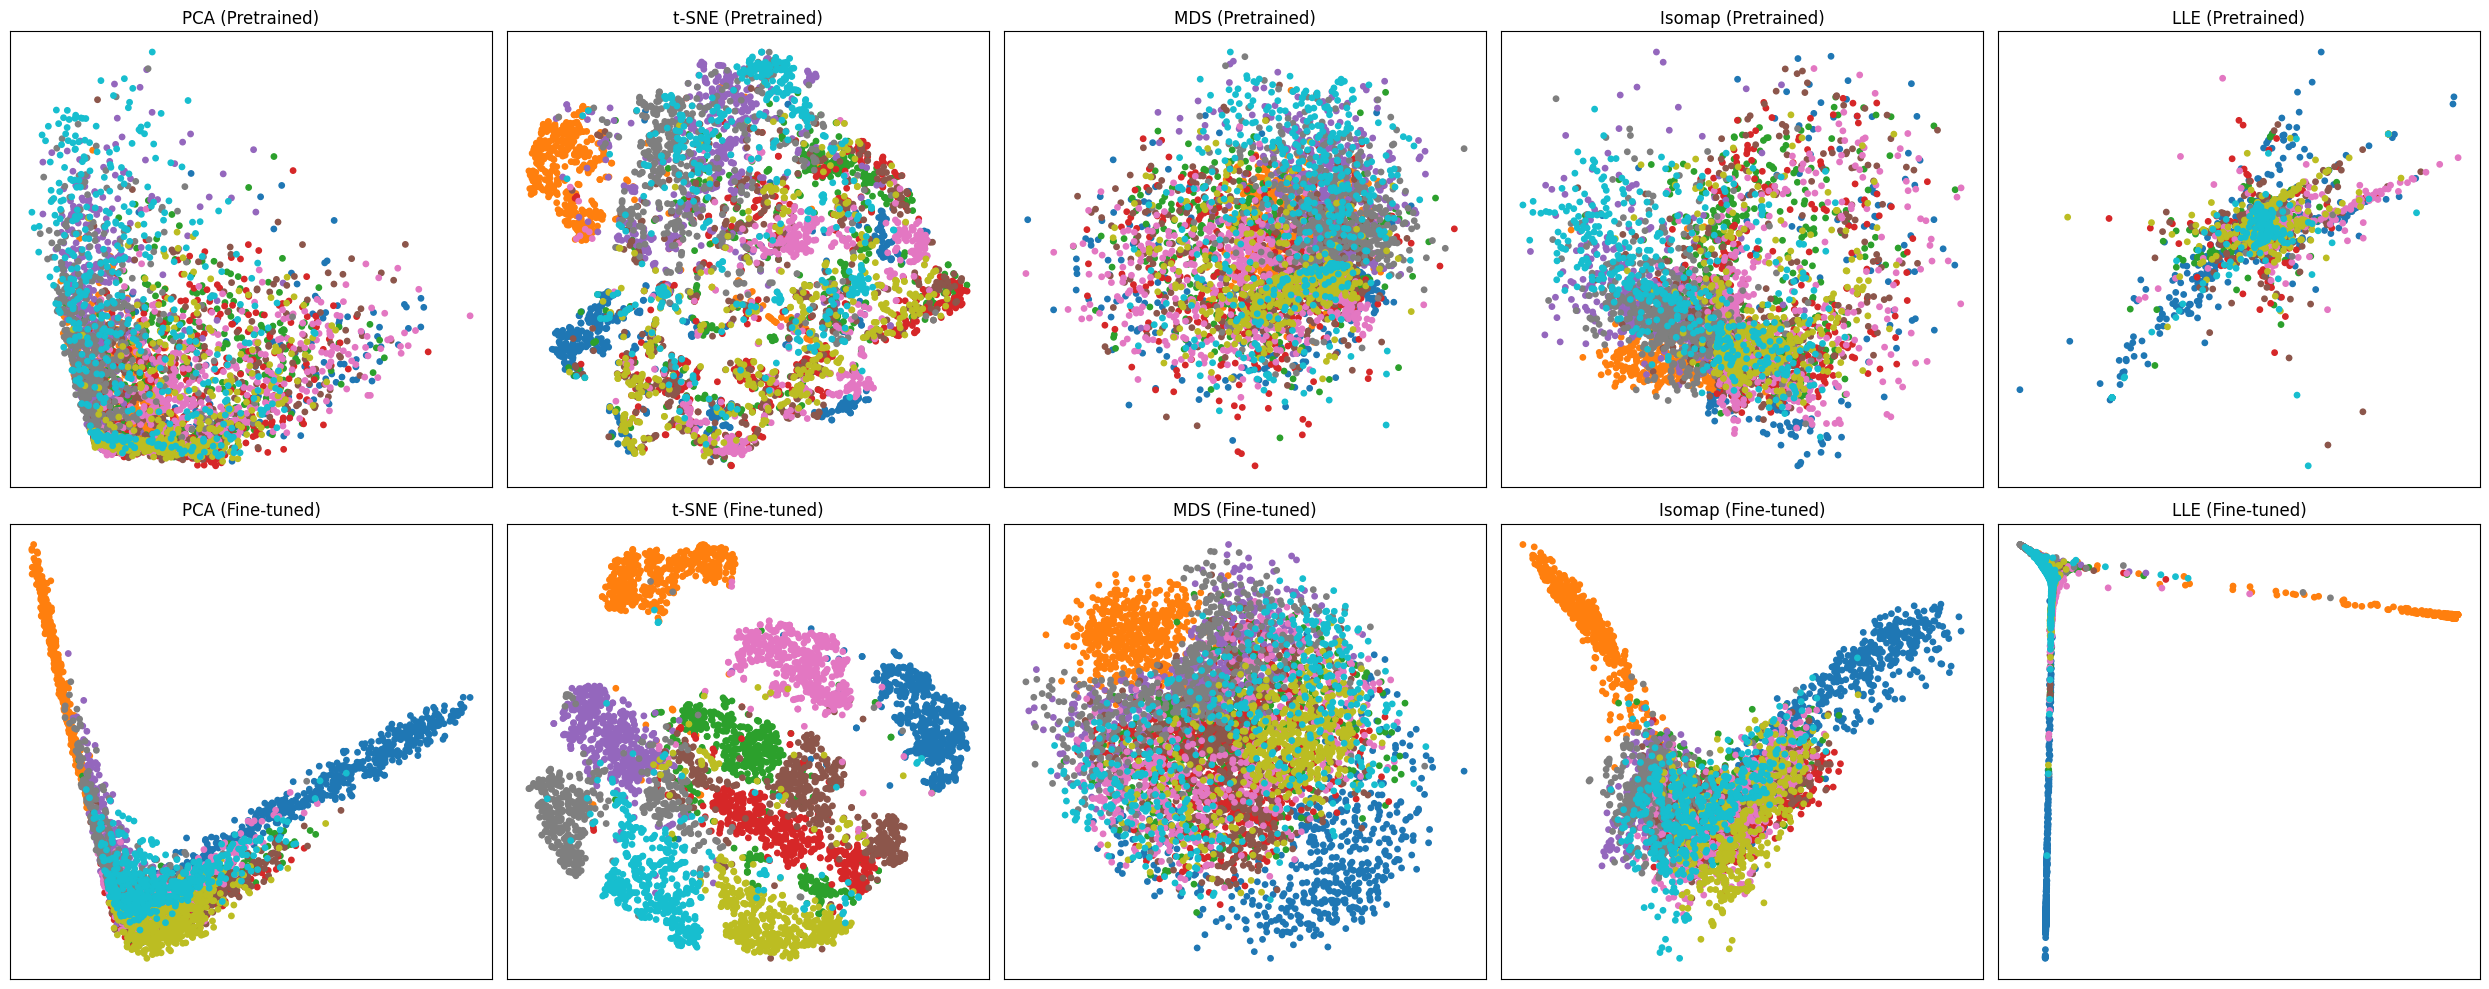

In [ ]:
plot_dim_reductions(pre_trained_features, fine_tuned_features, y_plot)